In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add, Activation, Input
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras import regularizers
import os
import glob 
import pandas as pd
import IPython.display as ipd
import plotly.express as px
import scipy.io.wavfile
import sys
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import kerastuner as kt

C:\Users\Anwender\AppData\Local\Temp\ipykernel_153620\1605315488.py:28: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
RAV = 'data/audio_speech_actors_01-24/'
dir_list = os.listdir(RAV)
emotion = []
gender = []
path = []
feature = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)
        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender'], axis=1)
RAV_df.labels.value_counts()

labels
male_neutral       144
female_neutral     144
male_happy          96
male_sad            96
male_angry          96
male_fear           96
male_disgust        96
male_surprise       96
female_happy        96
female_sad          96
female_angry        96
female_fear         96
female_disgust      96
female_surprise     96
Name: count, dtype: int64

In [3]:
display(RAV_df.head())
display(RAV_df.describe())

,emotion,labels,source,path
0,neutral,male_neutral,RAVDESS,data/audio_speech_actors_01-24/Actor_01/03-01-...
1,neutral,male_neutral,RAVDESS,data/audio_speech_actors_01-24/Actor_01/03-01-...
2,neutral,male_neutral,RAVDESS,data/audio_speech_actors_01-24/Actor_01/03-01-...
3,neutral,male_neutral,RAVDESS,data/audio_speech_actors_01-24/Actor_01/03-01-...
4,neutral,male_neutral,RAVDESS,data/audio_speech_actors_01-24/Actor_01/03-01-...


,emotion,labels,source,path
count,1440,1440,1440,1440
unique,7,14,1,1440
top,neutral,male_neutral,RAVDESS,data/audio_speech_actors_01-24/Actor_01/03-01-...
freq,288,144,1440,1


In [4]:
px_fig = px.histogram(RAV_df, x='emotion', color='emotion', marginal='box',  
                      title='Emotion Count')
px_fig.update_layout(bargap=0.2)
px_fig.show()

px_fig = px.histogram(RAV_df, x='labels', color='emotion', marginal='box',  
                      title='Label Count')
px_fig.update_layout(bargap=0.2)
px_fig.show()

In [5]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

In [6]:
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

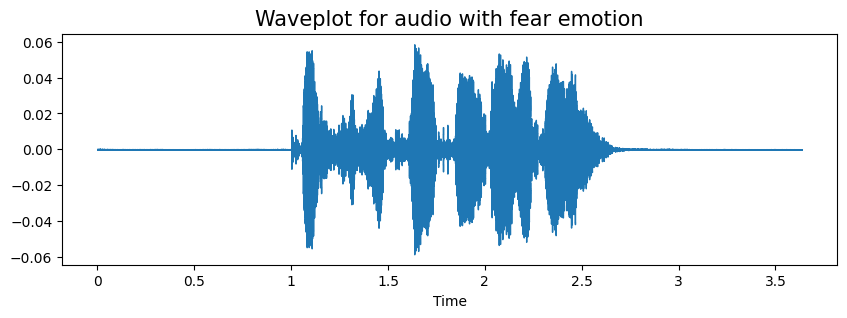

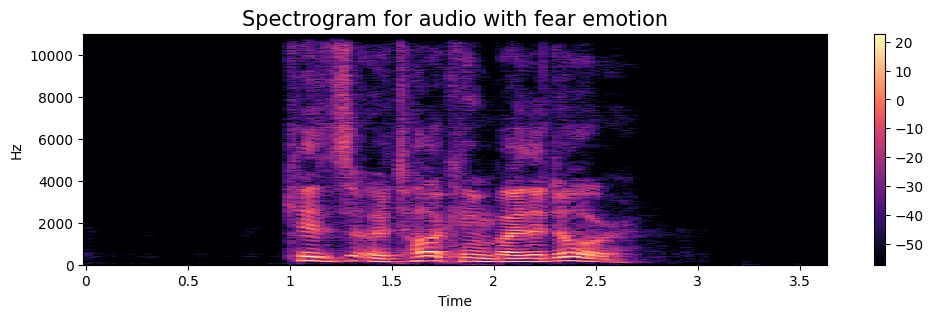

In [7]:
emotion='fear'
path = np.array(RAV_df.path[RAV_df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
ipd.Audio(path)

In [8]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(RAV_df.path)[1]
data, sample_rate = librosa.load(path)

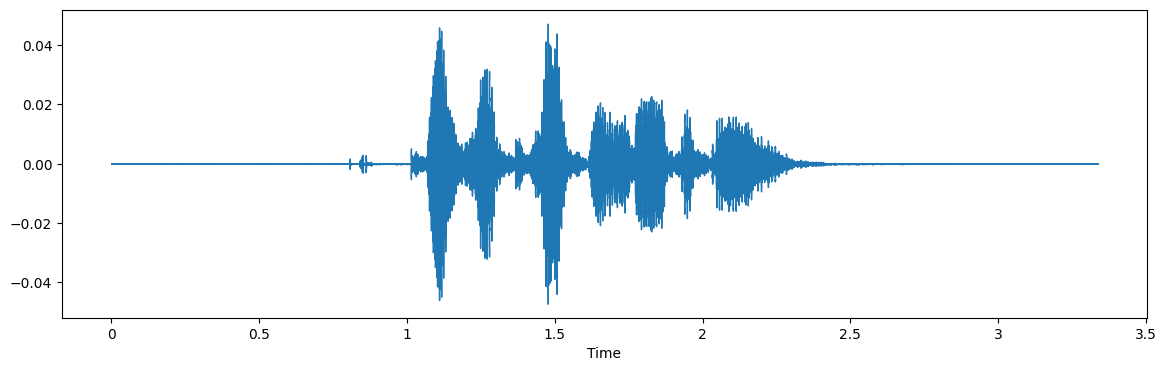

In [9]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
ipd.Audio(path)

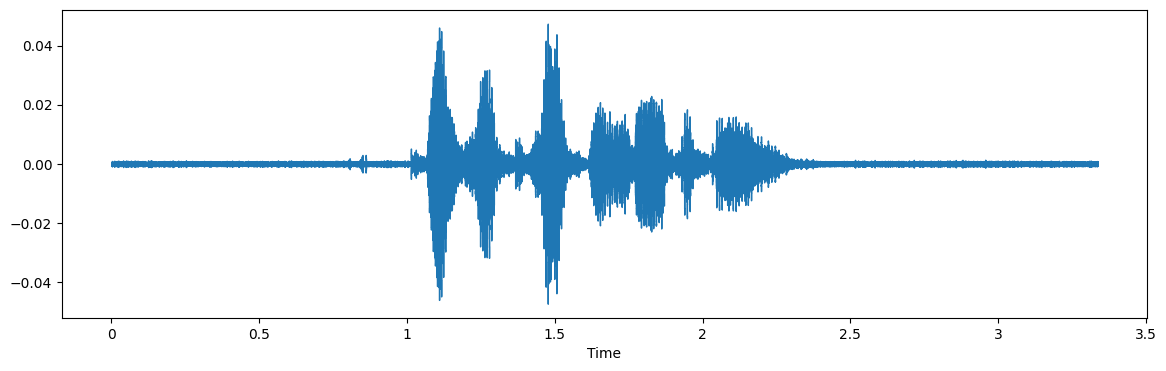

In [10]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)


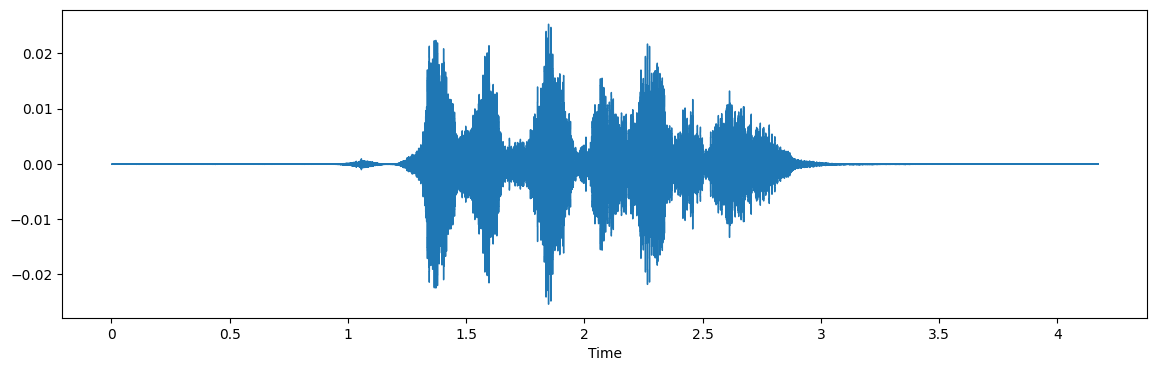

In [11]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

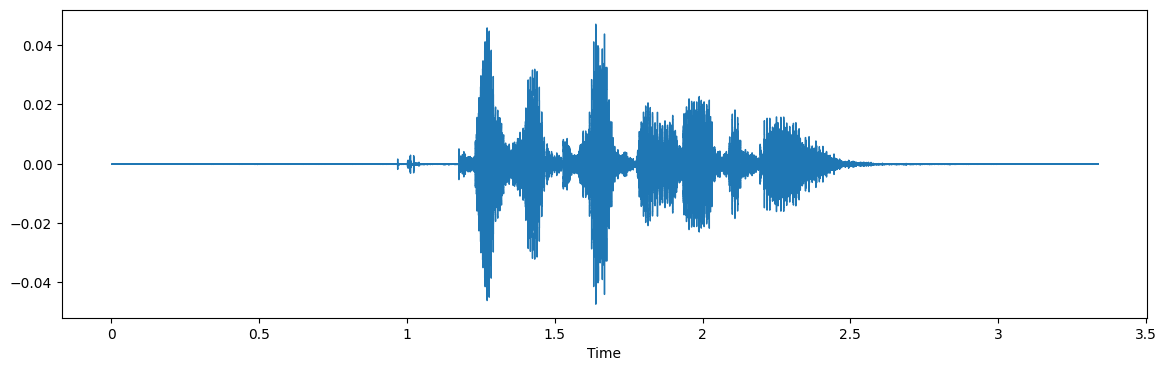

In [12]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

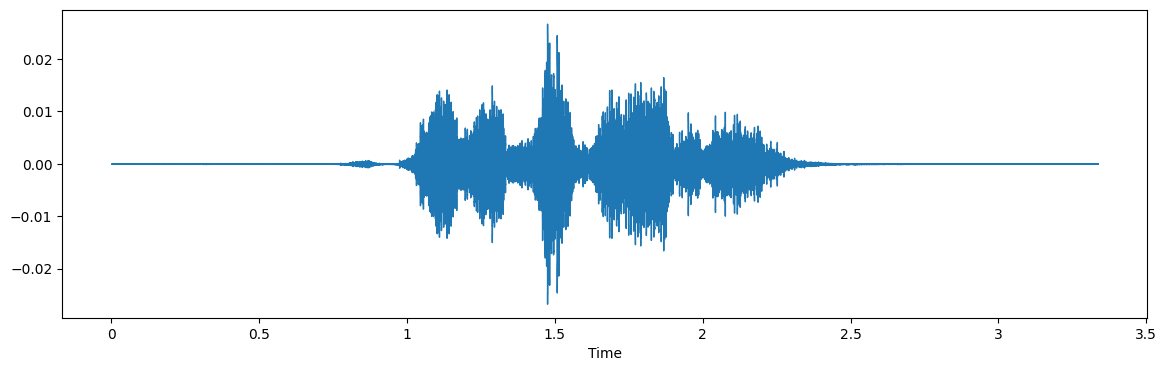

In [13]:
x = pitch(data,sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

In [14]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [15]:
X, Y = [], []
for path, emotion in zip(RAV_df.path, RAV_df.emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [16]:
len(X), len(Y), RAV_df.path.shape

(4320, 4320, (1440,))

In [17]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)

In [18]:
display(Features.head())
display(Features.describe())

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.321275,0.729664,0.750032,0.730624,0.735275,0.713529,0.660531,0.684966,0.733049,0.753972,...,4.310903e-06,3.291511e-06,2.148075e-06,2.279739e-06,5.116492e-06,8.190282e-06,0.000007,0.000005,4.245835e-07,neutral
1,0.281462,0.771777,0.779847,0.762590,0.773029,0.778137,0.686033,0.680339,0.731736,0.757889,...,6.422849e-06,5.309759e-06,4.375344e-06,4.586931e-06,7.416963e-06,1.062457e-05,0.000009,0.000007,2.500028e-06,neutral
2,0.188256,0.622125,0.699215,0.753343,0.721212,0.701727,0.682356,0.662828,0.686486,0.733960,...,8.579052e-07,9.576654e-07,7.733596e-07,5.233101e-07,3.592860e-07,9.261693e-07,0.000002,0.000001,7.753986e-08,neutral
3,0.293566,0.673896,0.722096,0.723508,0.682302,0.680533,0.675352,0.628977,0.679179,0.707283,...,6.984504e-06,7.034950e-06,6.654922e-06,6.979548e-06,1.214236e-05,9.640185e-06,0.000011,0.000006,4.254087e-07,neutral
4,0.321502,0.769780,0.810860,0.822490,0.783690,0.793653,0.775095,0.671687,0.695909,0.734228,...,9.431677e-05,9.524759e-05,1.001051e-04,9.551381e-05,9.479096e-05,9.347364e-05,0.000104,0.000095,8.614698e-05,neutral


,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
count,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,...,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03
mean,0.210508,0.627885,0.630976,0.635886,0.645873,0.634877,0.606676,0.600772,0.619763,0.637219,...,1.702426e-03,1.715701e-03,1.761002e-03,1.796404e-03,1.842009e-03,1.875314e-03,1.873837e-03,1.835406e-03,1.334409e-03,7.033157e-04
std,0.068552,0.087800,0.097474,0.100434,0.101926,0.104448,0.091483,0.078634,0.080453,0.078874,...,5.576419e-03,5.632426e-03,5.803461e-03,6.055962e-03,6.299456e-03,6.326218e-03,6.155980e-03,5.872597e-03,4.802000e-03,3.804725e-03
min,0.060041,0.339261,0.287358,0.274466,0.261137,0.263631,0.269492,0.262952,0.242527,0.269619,...,2.135675e-08,1.693106e-08,2.129188e-08,2.401496e-08,2.901139e-08,2.325078e-08,6.040970e-08,7.742658e-08,3.496133e-08,2.158315e-09
25%,0.154883,0.569161,0.565111,0.566413,0.575772,0.565044,0.549716,0.554157,0.568911,0.585458,...,2.877276e-05,2.942723e-05,3.068577e-05,3.206820e-05,3.503240e-05,3.402157e-05,3.464845e-05,3.372116e-05,2.017888e-05,1.977844e-06
50%,0.201572,0.629879,0.635830,0.641543,0.653174,0.643518,0.615695,0.609363,0.626513,0.643716,...,1.701553e-04,1.716639e-04,1.730233e-04,1.856855e-04,1.888471e-04,1.848117e-04,1.888904e-04,1.831115e-04,1.150366e-04,1.438462e-05
75%,0.266634,0.691780,0.702252,0.710294,0.721612,0.709366,0.670828,0.656013,0.677156,0.693586,...,8.629281e-04,8.698894e-04,9.192718e-04,8.989673e-04,9.276902e-04,9.422733e-04,9.324145e-04,9.358785e-04,5.993312e-04,1.099649e-04
max,0.395657,0.866572,0.868897,0.892742,0.895669,0.900355,0.878273,0.790552,0.826047,0.868182,...,1.041308e-01,1.061813e-01,9.312602e-02,1.160205e-01,1.330370e-01,1.228976e-01,9.594476e-02,9.652827e-02,9.110958e-02,6.363860e-02


In [19]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [20]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 7), (1080, 162), (1080, 7))

In [22]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 7), (1080, 162), (1080, 7))

In [23]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 7), (1080, 162, 1), (1080, 7))

In [24]:
# # Hyperparameter Optimierung
# def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
#     # Normalization and Attention
#     x = LayerNormalization(epsilon=1e-6)(inputs)
#     x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
#     x = Dropout(dropout)(x)
#     res = Add()([x, inputs])

#     # Feed Forward Part
#     x = LayerNormalization(epsilon=1e-6)(res)
#     x = Dense(ff_dim, activation="relu")(x)
#     x = Dropout(dropout)(x)
#     x = Dense(inputs.shape[-1])(x)
#     return Add()([x, res])

# def build_model(hp):
#     inputs = Input(shape=(x_train.shape[1], 1))

#     # Erste Convolutional-Schicht
#     x = Conv1D(
#         filters=hp.Int('conv_1_filter', min_value=32, max_value=256, step=32),
#         kernel_size=hp.Choice('conv_1_kernel', values=[3, 5, 7]),
#         activation='relu'
#     )(inputs)
#     x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)

#     # Zweite Convolutional-Schicht
#     x = Conv1D(
#         filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=32),
#         kernel_size=hp.Choice('conv_2_kernel', values=[3, 5, 7]),
#         activation='relu'
#     )(x)
#     x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)

#     # Dritte Convolutional-Schicht
#     x = Conv1D(
#         filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=32),
#         kernel_size=hp.Choice('conv_3_kernel', values=[3, 5, 7]),
#         activation='relu'
#     )(x)
#     x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)

#     # Vierte Convolutional-Schicht
#     x = Conv1D(
#         filters=hp.Int('conv_4_filter', min_value=32, max_value=64, step=32),
#         kernel_size=hp.Choice('conv_4_kernel', values=[3, 5, 7]),
#         activation='relu'
#     )(x)
#     x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)

#     # Transformer Encoder
#     x = transformer_encoder(x, head_size=hp.Choice('head_size', values=[128, 256, 512]), num_heads=hp.Int('num_heads', min_value=2, max_value=8, step=2), ff_dim=hp.Int('ff_dim', min_value=128, max_value=512, step=128), dropout=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1))
#     x = transformer_encoder(x, head_size=hp.Choice('head_size', values=[128, 256, 512]), num_heads=hp.Int('num_heads', min_value=2, max_value=8, step=2), ff_dim=hp.Int('ff_dim', min_value=128, max_value=512, step=128), dropout=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1))

#     x = GlobalAveragePooling1D()(x)

#     # Dichte Schichten
#     x = Dense(hp.Int('dense_1_units', min_value=32, max_value=128, step=32), activation='relu')(x)
#     x = Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1))(x)
#     x = Dense(hp.Int('dense_2_units', min_value=16, max_value=64, step=16), activation='relu')(x)
#     x = Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1))(x)
#     num_classes = 7
#     # Ausgabeschicht
#     outputs = Dense(num_classes, activation='softmax')(x)

#     # Modell erstellen
#     model = Model(inputs, outputs)

#     # Modell kompilieren
#     model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')), loss='categorical_crossentropy', metrics=['accuracy'])

#     return model

# # Hyperparameter-Tuner
# tuner = kt.Hyperband(
#     build_model,
#     objective='val_accuracy',
#     max_epochs=20,
#     factor=3,
#     directory='my_dir',
#     project_name='audio_sentiment_analysis'
# )

# # Frühes Stoppen, um Überanpassung zu vermeiden
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Suche nach den besten Hyperparametern
# tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping])

# # Beste Hyperparameter extrahieren
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# print(f"""
# Beste Hyperparameter:
# - Convolution 1 Filter: {best_hps.get('conv_1_filter')}
# - Convolution 1 Kernel: {best_hps.get('conv_1_kernel')}
# - Convolution 2 Filter: {best_hps.get('conv_2_filter')}
# - Convolution 2 Kernel: {best_hps.get('conv_2_kernel')}
# - Convolution 3 Filter: {best_hps.get('conv_3_filter')}
# - Convolution 3 Kernel: {best_hps.get('conv_3_kernel')}
# - Convolution 4 Filter: {best_hps.get('conv_4_filter')}
# - Convolution 4 Kernel: {best_hps.get('conv_4_kernel')}
# - Head Size: {best_hps.get('head_size')}
# - Number of Heads: {best_hps.get('num_heads')}
# - Feed Forward Dimension: {best_hps.get('ff_dim')}
# - Dropout: {best_hps.get('dropout')}
# - Dense 1 Units: {best_hps.get('dense_1_units')}
# - Dropout 1: {best_hps.get('dropout_1')}
# - Dense 2 Units: {best_hps.get('dense_2_units')}
# - Dropout 2: {best_hps.get('dropout_2')}
# - Learning Rate: {best_hps.get('learning_rate')}
# """)

# # Trainiere das beste Modell mit den gefundenen Hyperparametern
# model = tuner.hypermodel.build(best_hps)
# history = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping])

In [25]:
# Approach 3 Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Erste Convolutional-Schicht
    x = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
    x = BatchNormalization()(x)

    # Zweite Convolutional-Schicht
    x = Conv1D(96, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
    x = BatchNormalization()(x)

    # Dritte Convolutional-Schicht
    x = Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
    x = BatchNormalization()(x)

    # Vierte Convolutional-Schicht
    x = Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
    x = BatchNormalization()(x)

    # Transformer Encoder
    x = transformer_encoder(x, head_size=512, num_heads=4, ff_dim=256, dropout=0.2)
    x = transformer_encoder(x, head_size=512, num_heads=4, ff_dim=256, dropout=0.2)

    x = GlobalAveragePooling1D()(x)

    # Dichte Schichten
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    # x = Dropout(0.3)(x)

    # Ausgabeschicht
    outputs = Dense(num_classes, activation='softmax')(x)

    # Modell erstellen
    model = Model(inputs, outputs)
    return model

# Eingabeform und Anzahl der Klassen
input_shape = (x_train.shape[1], 1)
num_classes = 7

# Modell aufbauen
model = build_model(input_shape, num_classes)

# Modell kompilieren
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Modellübersicht
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 162, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 162, 256)  │      1,536 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 81, 256)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 81, 256)   │      1,024 │ max_pooling1d[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 81, 96)    │     73,824 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 41, 96)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 41, 96)    │        384 │ max_pooling1d_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 41, 64)    │     18,496 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 21, 64)    │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 64)    │        256 │ max_pooling1d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 21, 64)    │     20,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 11, 64)    │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 64)    │        256 │ max_pooling1d_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 11, 64)    │        128 │ batch_normalizat… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 11, 64)    │    530,496 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 11, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 11, 64)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 11, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,256,679 (4.79 MB)

 Trainable params: 1,255,719 (4.79 MB)

 Non-trainable params: 960 (3.75 KB)

In [26]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 162, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 162, 256)  │      1,536 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 81, 256)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 81, 256)   │      1,024 │ max_pooling1d[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 81, 96)    │     73,824 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 41, 96)    │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 41, 96)    │        384 │ max_pooling1d_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 41, 64)    │     18,496 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 21, 64)    │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 64)    │        256 │ max_pooling1d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 21, 64)    │     20,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 11, 64)    │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 64)    │        256 │ max_pooling1d_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 11, 64)    │        128 │ batch_normalizat… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 11, 64)    │    530,496 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 11, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 11, 64)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 11, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,256,679 (4.79 MB)

 Trainable params: 1,255,719 (4.79 MB)

 Non-trainable params: 960 (3.75 KB)

In [27]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr=0.000007)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.3051 - loss: 1.8113 - val_accuracy: 0.2185 - val_loss: 3.9992 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.3397 - loss: 1.6857 - val_accuracy: 0.2935 - val_loss: 2.1602 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.3996 - loss: 1.5372 - val_accuracy: 0.2574 - val_loss: 2.2041 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4516 - loss: 1.4000 - val_accuracy: 0.2870 - val_loss: 1.9591 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5051 - loss: 1.3017 - val_accuracy: 0.1611 - val_loss: 3.5545 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5503 - loss: 1.1663 - val_accuracy: 0.1278 - val_loss: 3.7398 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6107 - loss: 1.0278 - val_acc

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7252 - loss: 1.7773
Accuracy of our model on test data :  73.70370626449585 %


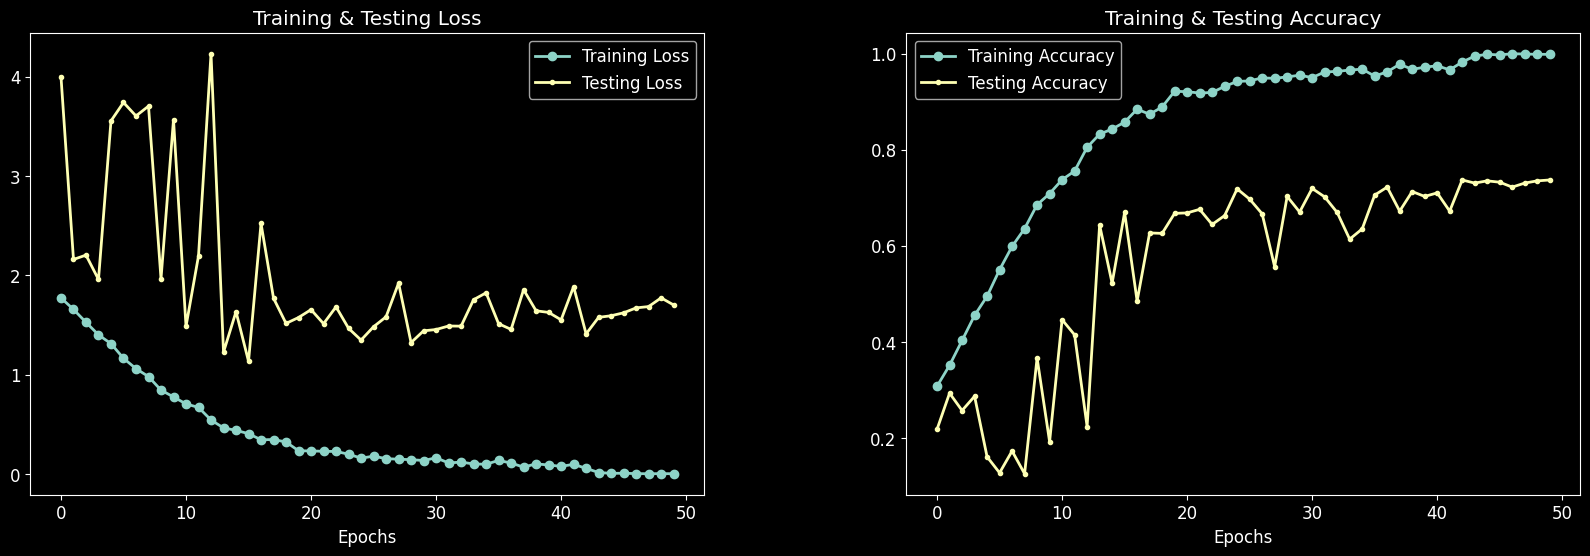

In [28]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

plt.style.use('dark_background')
plt.rcParams.update({'font.size': 12})
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss',marker='o', linewidth=2)
ax[0].plot(epochs , test_loss , label = 'Testing Loss',marker='.', linewidth=2)
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy',marker='o', linewidth=2)
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy',marker='.', linewidth=2)
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.subplots_adjust(wspace=0.3)
plt.show()

In [29]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [30]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

display(df.head())

,Predicted Labels,Actual Labels
0,fear,fear
1,happy,angry
2,fear,fear
3,neutral,neutral
4,disgust,angry


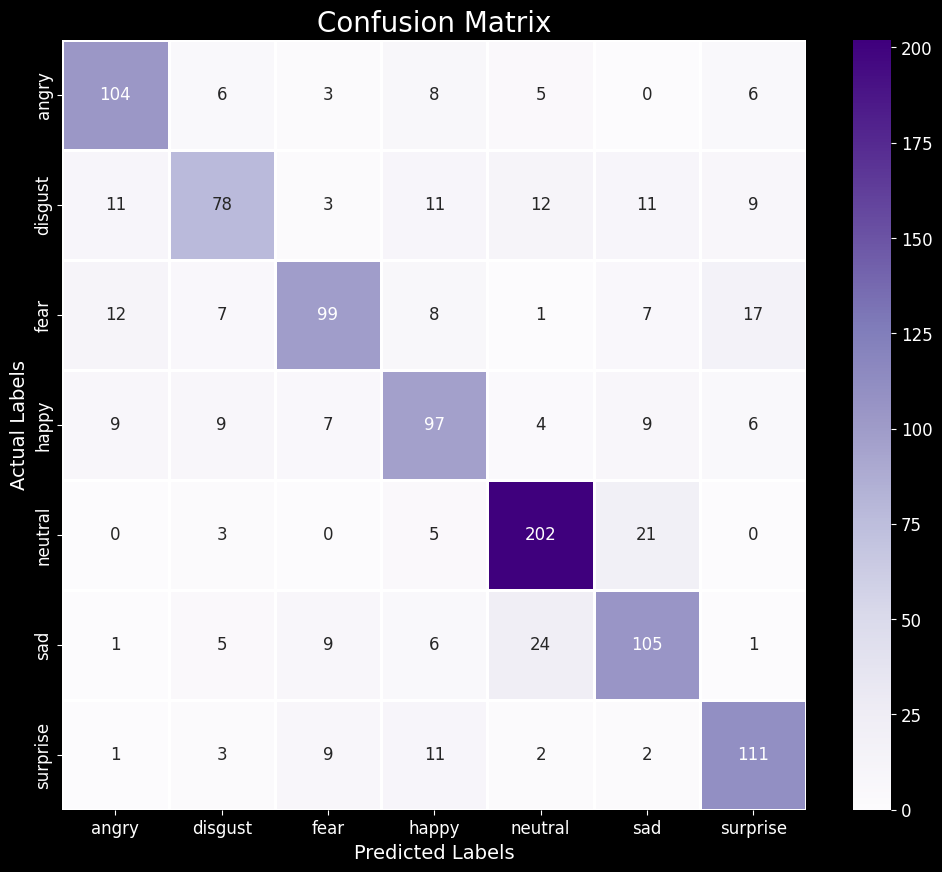

In [31]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Purples', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [33]:
# # Save Model
# import pickle

# # save the iris classification model as a pickle file
# model_pkl_file = "model_3.pkl"  

# with open(model_pkl_file, 'wb') as file:  
#     pickle.dump(model, file)